# Oxford-IIIT Pets Dataset Viewer

We load the Oxford-IIIT Pets dataset utilities from `ktf`. Note that we insert the `ktf` path in the python search path with `sys.path.insert(0, ...)`. This is a common pattern that we will use when we execute scripts that need to use the `ktf` package, but without needing to `pip install` it.

In [1]:
import io
import os
import sys
ktf_python_root = os.path.join(os.getcwd(), "../../..")
sys.path.insert(0, ktf_python_root)

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import PIL.ImageDraw as ImageDraw

import ktf.datasets
import ktf.datasets.animals.oxford_iiit_pets

2021-08-06 08:44:09.335221: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


`oxford_iiit_pets_dir` should point to the folder containing the unzipped raw Oxford-IIIT Pets Dataset files.  
The files were obtained from https://www.robots.ox.ac.uk/~vgg/data/pets/ 

In [2]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax,
                               color='red', thickness=4,
                               use_normalized_coordinates=True):
    """Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    If the top of the bounding box extends to the edge of the image, the strings
    are displayed below the bounding box.
    Args:
        image: a PIL.Image object.
        ymin: ymin of bounding box.
        xmin: xmin of bounding box.
        ymax: ymax of bounding box.
        xmax: xmax of bounding box.
        color: color to draw bounding box. Default is red.
        thickness: line thickness. Default value is 4.
        use_normalized_coordinates: If True (default), treat coordinates
        ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
        coordinates as absolute.
    """
    image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
    draw = ImageDraw.Draw(image_pil)
    im_width, im_height = image_pil.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                      ymin * im_height, ymax * im_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    if thickness > 0:
        draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
                  width=thickness, fill=color)
    np.copyto(image, np.array(image_pil))

In [3]:
hpc_datasets_path = "/hpc-datasets"
oxford_iiit_pets_dir = os.path.join(hpc_datasets_path, "animals", "oxford_iiit_pets", "raw")

Iterate through the **raw** data using the `ktf.datasets.animals.oxford_iiit_pets.Parser` object:

2021-08-06 08:44:10.619296: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-06 08:44:10.680950: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-06 08:44:10.681402: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2021-08-06 08:44:10.681429: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-06 08:44:10.684856: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-06 08:44:10.684904: I tensorflow/stream_executor/platf

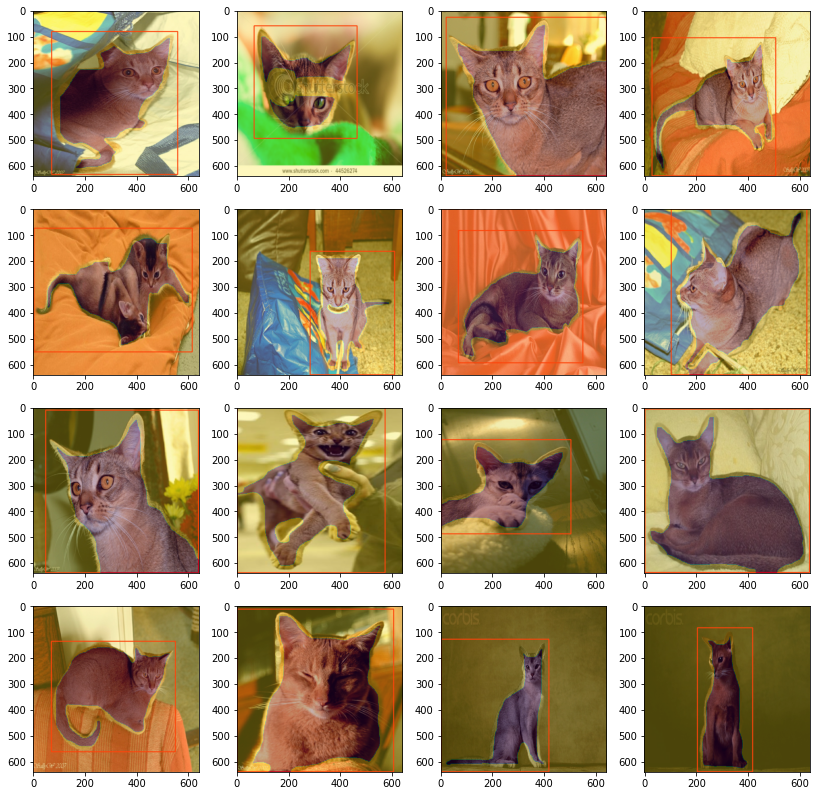

In [4]:
fig = plt.figure(figsize=(14, 14))

parser = ktf.datasets.animals.oxford_iiit_pets.Parser(oxford_iiit_pets_dir)
for i, (img, bbox, label, mask) in enumerate(parser.parse()):
    ax = fig.add_subplot(4, 4, i+1)
    y_min, x_min, y_max, x_max = bbox
    img = tf.io.decode_jpeg(img).numpy()
    draw_bounding_box_on_image(img, y_min, x_min, y_max, x_max)
    plt.imshow(img)
    mask = tf.io.decode_jpeg(mask).numpy()
    plt.imshow(mask, alpha=0.3)
    if i >= 4*4-1:
        break

We can also read more optimally using `.tfrecord` files that we convert from raw data.
For a script that does this see: `/ktf/datasets/animals/oxford_iiit_pets/raw_to_tfrecord.py`

In [5]:
oxford_iiit_pets_tf_dir = os.path.join(hpc_datasets_path, "animals", "oxford_iiit_pets", "tfrecord", "640x640_no_pad")

Given the directory of tfrecords, we retrieve the tensorflow Dataset object(s) for both training and validation (using the default 80/20 split), batched and shuffled, and plot the results as before

Instructions for updating:
Use fn_output_signature instead


2021-08-06 08:44:16.573703: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-06 08:44:16.597067: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2199995000 Hz


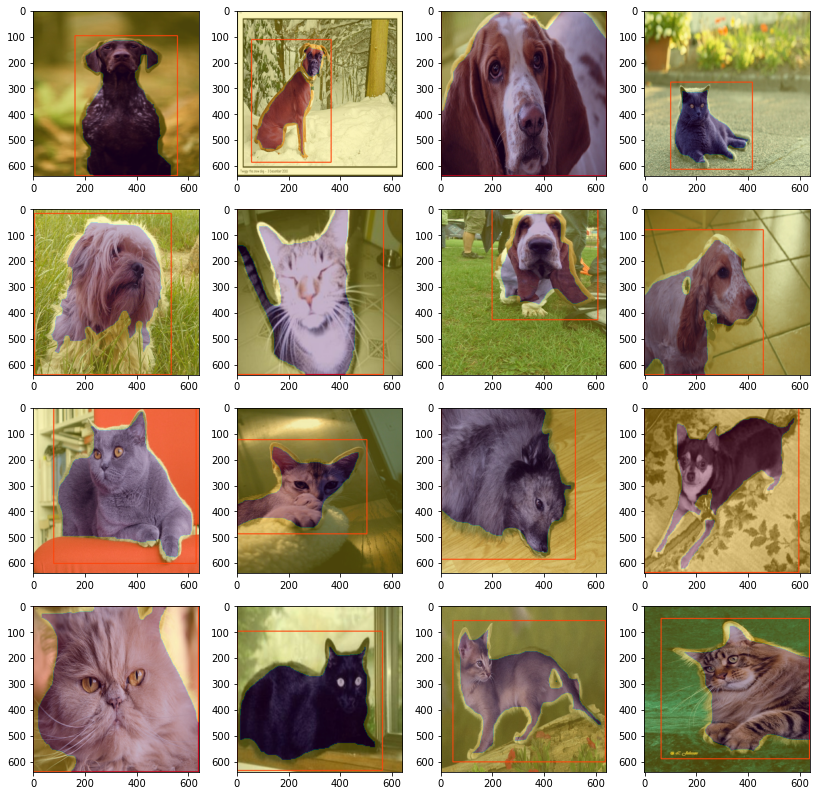

In [6]:
fig = plt.figure(figsize=(14, 14))

train_dataset, _ = ktf.datasets.animals.oxford_iiit_pets.from_tfrecord(oxford_iiit_pets_tf_dir, shuffle_size=1024, batch_size=16)
img_batch, (bbox_batch, label_batch, mask_batch) = next(iter(train_dataset))
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    img = img_batch[i].numpy().astype(int)
    y_min, x_min, y_max, x_max = bbox_batch[i].numpy().flatten()
    draw_bounding_box_on_image(img, y_min, x_min, y_max, x_max)
    plt.imshow(img)
    plt.imshow(np.squeeze(mask_batch[i]), alpha=0.3)